In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import accuracy_score, r2_score, precision_score, precision_recall_curve
from sklearn.tree import DecisionTreeClassifier

In [2]:
df = pd.read_csv('../data/raw/healthcare-dataset-stroke-data.csv.xls')

# LIMPIEZA 

Empezamos viendo información y métricas del dataset

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [4]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


Podemos observar que tenemos varias variables binarias, algunas numericas y otras categoricas. Empecemos:

Eliminaremos los registros que no contengan información sobre el indice de masa corporal, al ser un dataset grande no nos representará ningún problema.

In [5]:
df = df.dropna(axis=0, how='any')

Preprocesaremos los datos para que funcionen en nuestro modelo:
1. Preprocesado de gender

In [24]:
df['stroke'].value_counts(normalize=True)

stroke
0    0.957416
1    0.042584
Name: proportion, dtype: float64

In [7]:
df.drop(index=3116, inplace=True)
df.insert(2, 'is male?', np.where(df['gender'] == 'Male', 10, 1))


2. Preprocesado de ever_married

In [8]:
df.insert(7, 'has ever married?', np.where(df['ever_married'] == 'Yes', 1, 0))

3. Grupos de edad

In [9]:
df.describe()

,id,is male?,age,hypertension,heart_disease,has ever married?,avg_glucose_level,bmi,stroke
count,4908.000000,4908.000000,4908.000000,4908.000000,4908.000000,4908.000000,4908.000000,4908.00000,4908.000000
mean,37060.423594,4.687653,42.868810,0.091891,0.049511,0.652812,105.297402,28.89456,0.042584
std,20995.468407,4.426521,22.556128,0.288901,0.216954,0.476125,44.425550,7.85432,0.201937
min,77.000000,1.000000,0.080000,0.000000,0.000000,0.000000,55.120000,10.30000,0.000000
25%,18602.500000,1.000000,25.000000,0.000000,0.000000,0.000000,77.067500,23.50000,0.000000
50%,37580.500000,1.000000,44.000000,0.000000,0.000000,1.000000,91.680000,28.10000,0.000000
75%,55181.750000,10.000000,60.000000,0.000000,0.000000,1.000000,113.495000,33.10000,0.000000
max,72940.000000,10.000000,82.000000,1.000000,1.000000,1.000000,271.740000,97.60000,1.000000


In [10]:
bins = [0,18, 40, 60, float('inf')] 
etiquetas = [0, 1, 2, 5]
df['AgeGroup'] = pd.cut(df['age'], bins=bins, labels=etiquetas, right=False).astype(int)

4. Rangos de BMI

In [11]:
bins = [0,18.5, 25, 30, 40, float('inf')] 
etiquetas = [0, 2, 3, 4, 5]
df['BmiRange'] = pd.cut(df['bmi'], bins=bins, labels=etiquetas, right=False).astype(int)

5. Tiene tanto enfermedades del corazón como hipertensión, tendrá un riesgo cardiovascular.

In [12]:
conditions = [
    (df['hypertension'] == 1) & (df['heart_disease'] == 1),
    (df['hypertension'] == 0) & (df['heart_disease'] == 1),
    (df['hypertension'] == 1) & (df['heart_disease'] == 0),
    (df['hypertension'] == 0) & (df['heart_disease'] == 0)
]
values = [100, 50, 25, 1]

df['cardiovascularRisk'] = np.select(conditions, values)

6. Tipo de trabajo

In [13]:
df['work_type'].unique()
worktype_map = {'Private':3, 'Self-employed':2, 'Govt_job':4, 'children': 0, 'Never_worked': 1}
df['work_type_num'] = df['work_type'].map(worktype_map)

In [14]:
df['Residence_type_num'] = np.where(df['Residence_type'] == 'Rural', 1, 2)

7. Nivel de glucosa medio o diabetes prevision

In [15]:
bins = [0, 100, 125, 180, float('inf')] 
etiquetas = [1, 10, 30, 100]
df['diabetes level'] = pd.cut(df['avg_glucose_level'], bins=bins, labels=etiquetas, right=False).astype(int)

8. Fumador categorias

In [16]:
fumador_map = {'formerly smoked': 25, 'never smoked':0, 'smokes':50, 'Unknown':0}
df['smoking_status_num'] = df['smoking_status'].map(fumador_map)
df['smokingbyAge'] = df['age'] * df['smoking_status_num']

In [17]:
df['smoking_status'].unique()

array(['formerly smoked', 'never smoked', 'smokes', 'Unknown'],
      dtype=object)

# Visualizaciones

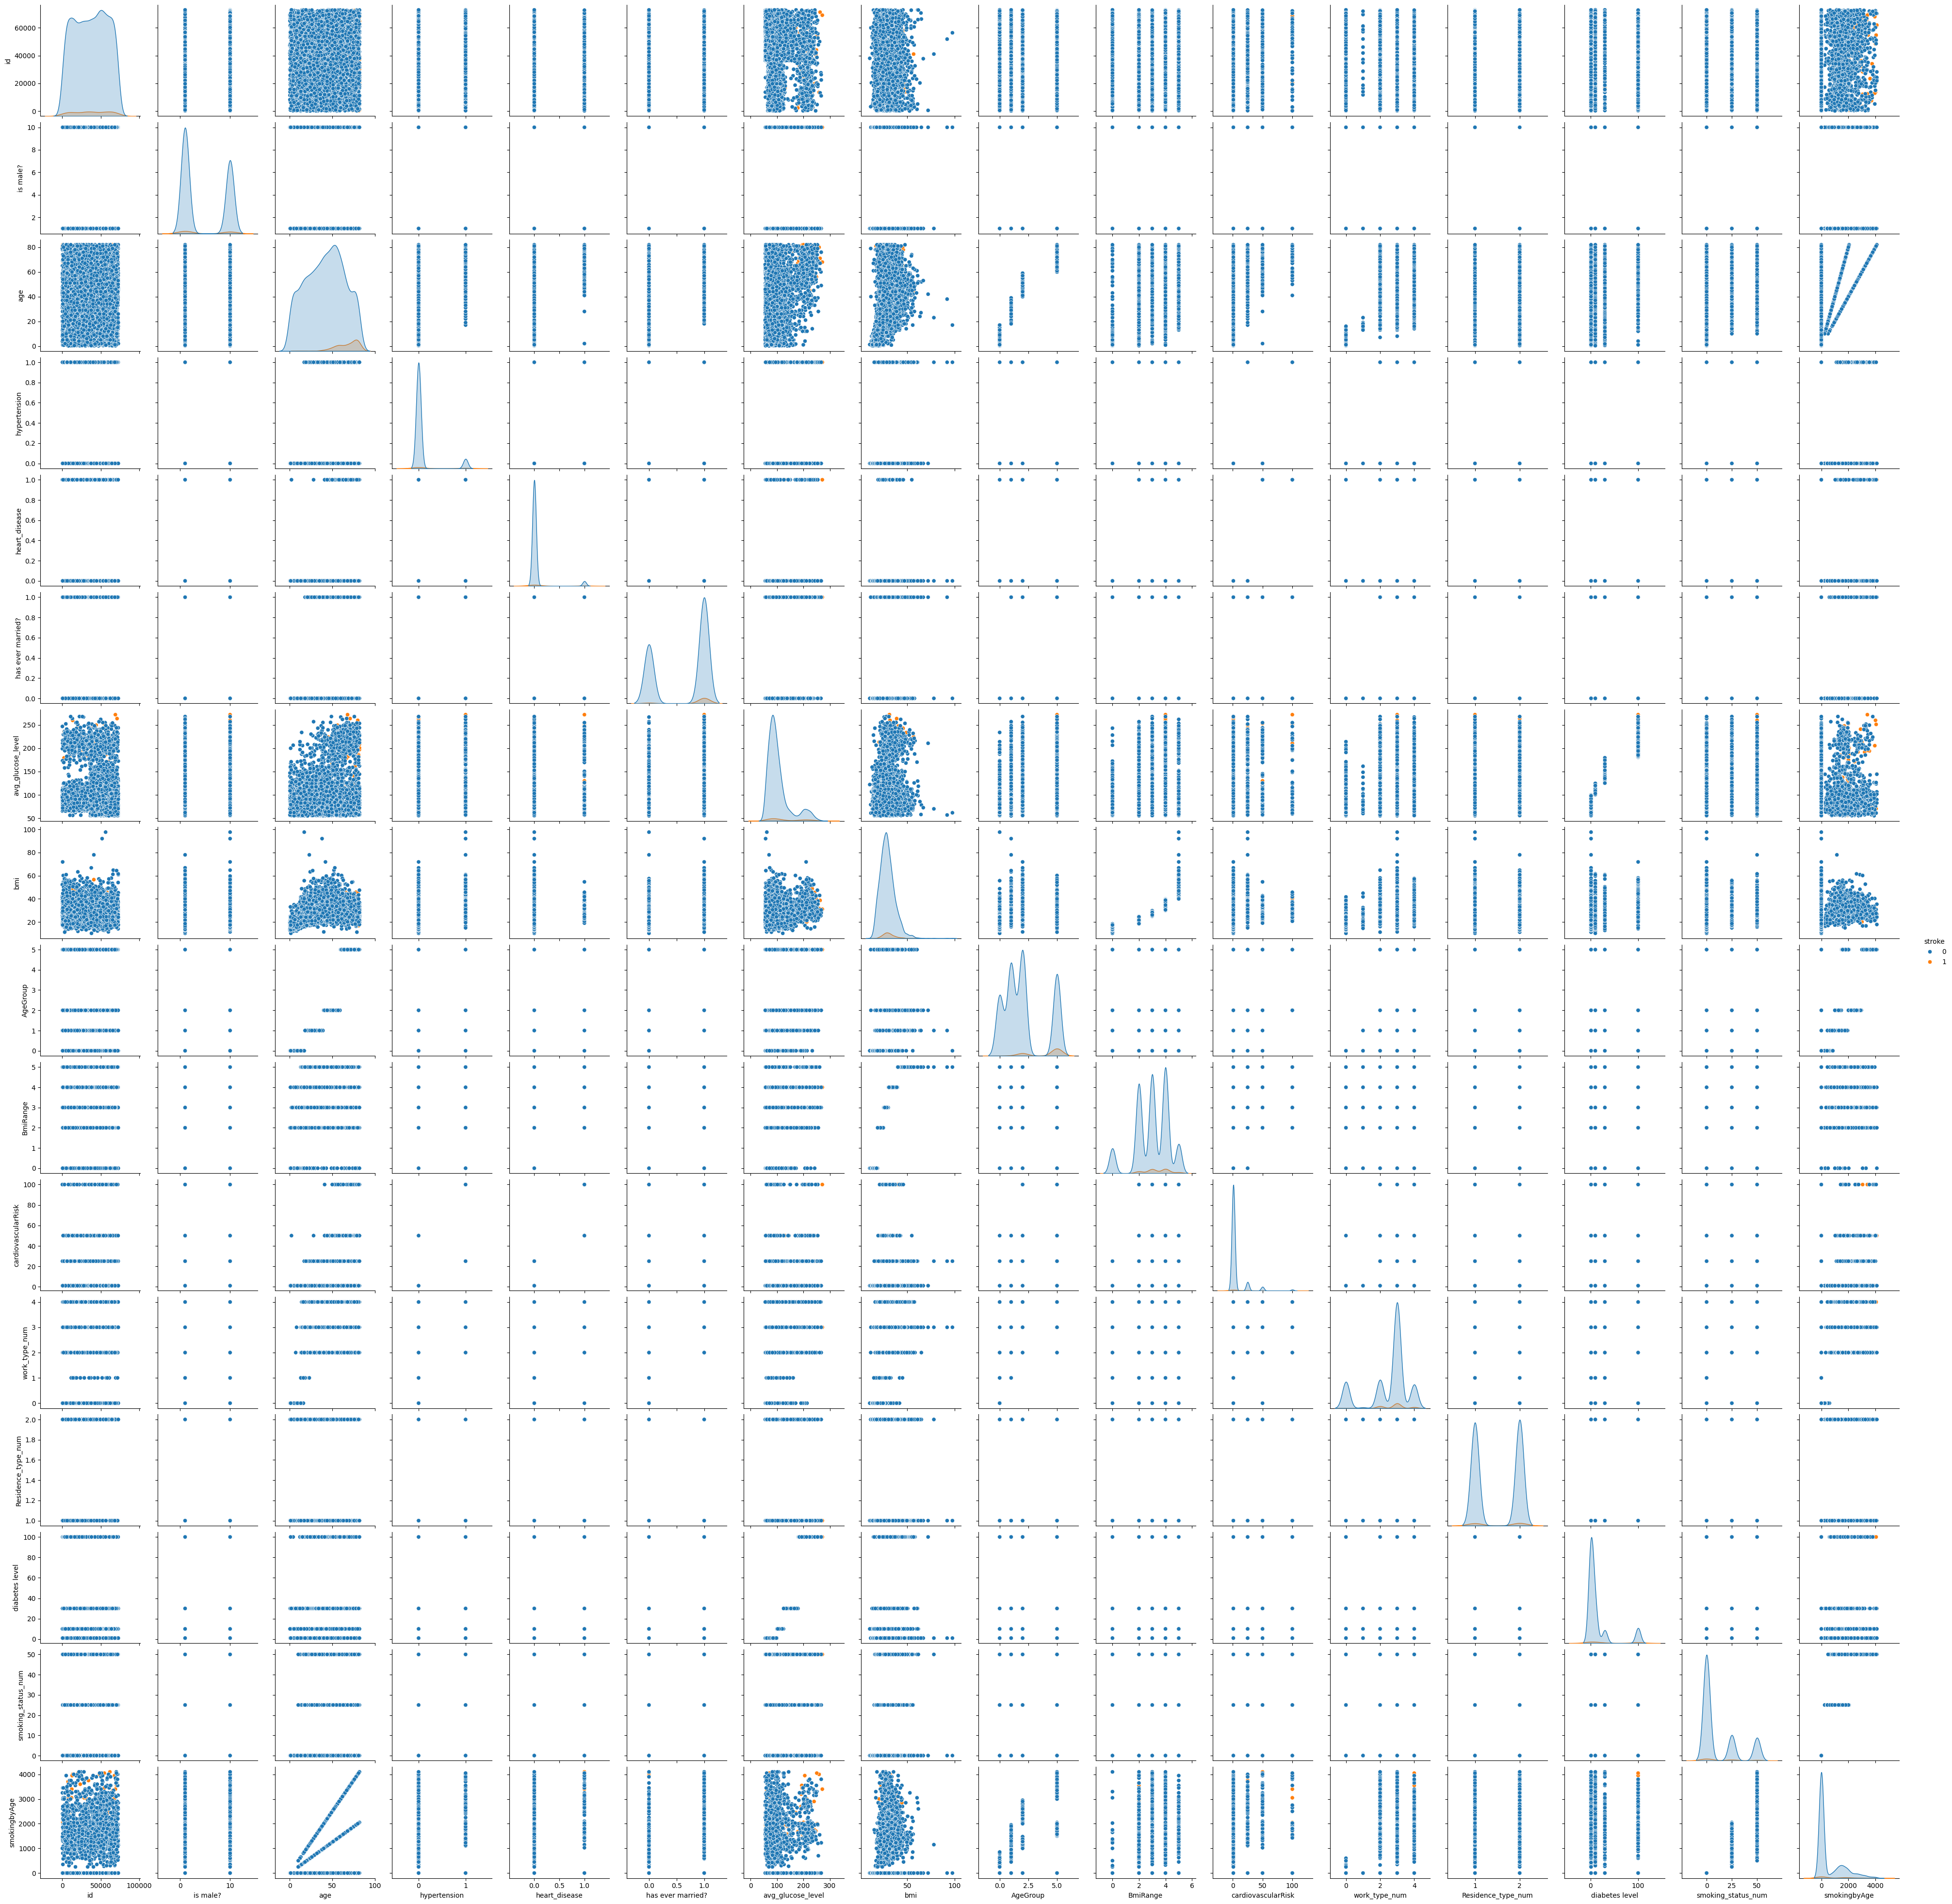

In [22]:
sns.pairplot(df, hue='stroke')

<Axes: >

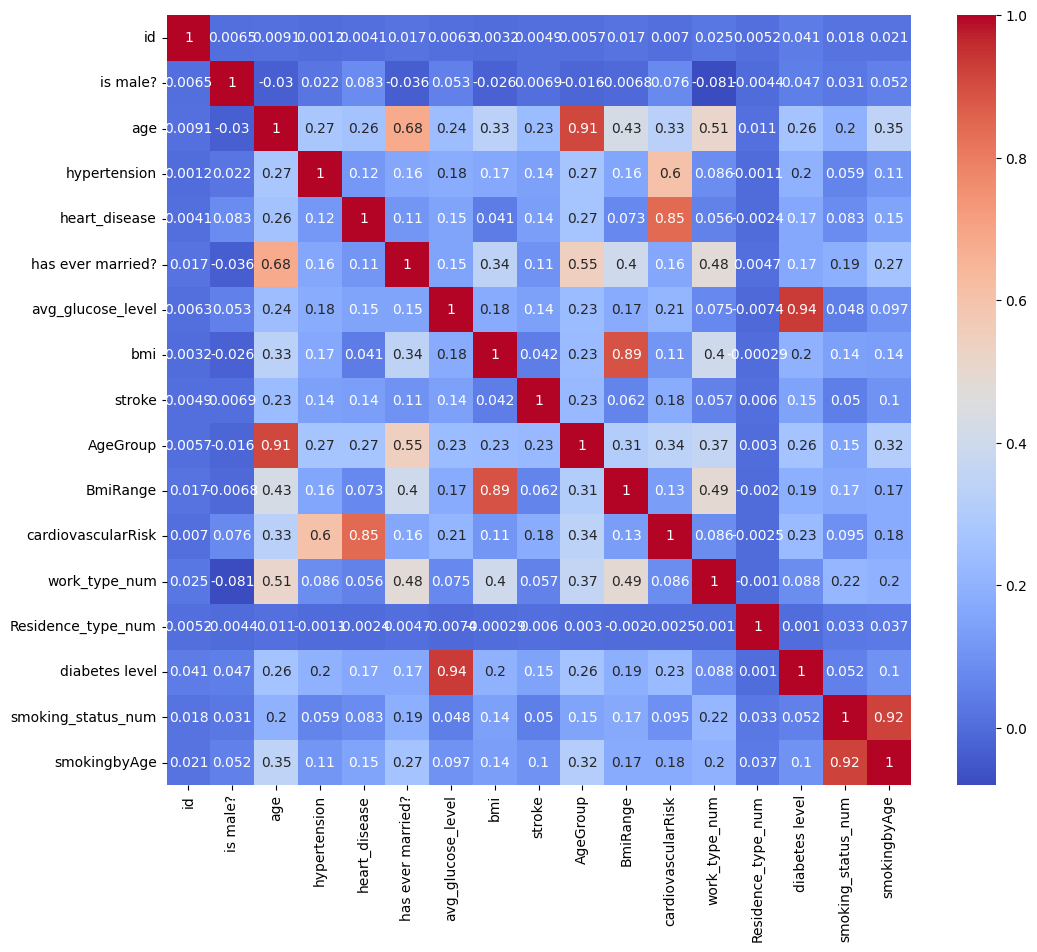

In [18]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")

In [19]:
df.to_csv('../data/processed/healthcare-dataset-processed.csv', index=False)

In [20]:
df

,id,gender,is male?,age,hypertension,heart_disease,ever_married,has ever married?,work_type,Residence_type,...,smoking_status,stroke,AgeGroup,BmiRange,cardiovascularRisk,work_type_num,Residence_type_num,diabetes level,smoking_status_num,smokingbyAge
0,9046,Male,10,67.0,0,1,Yes,1,Private,Urban,...,formerly smoked,1,5,4,50,3,2,100,25,1675.0
2,31112,Male,10,80.0,0,1,Yes,1,Private,Rural,...,never smoked,1,5,4,50,3,1,10,0,0.0
3,60182,Female,1,49.0,0,0,Yes,1,Private,Urban,...,smokes,1,2,4,1,3,2,30,50,2450.0
4,1665,Female,1,79.0,1,0,Yes,1,Self-employed,Rural,...,never smoked,1,5,2,25,2,1,30,0,0.0
5,56669,Male,10,81.0,0,0,Yes,1,Private,Urban,...,formerly smoked,1,5,3,1,3,2,100,25,2025.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5104,14180,Female,1,13.0,0,0,No,0,children,Rural,...,Unknown,0,0,2,1,0,1,10,0,0.0
5106,44873,Female,1,81.0,0,0,Yes,1,Self-employed,Urban,...,never smoked,0,5,5,1,2,2,30,0,0.0
5107,19723,Female,1,35.0,0,0,Yes,1,Self-employed,Rural,...,never smoked,0,1,4,1,2,1,1,0,0.0
5108,37544,Male,10,51.0,0,0,Yes,1,Private,Rural,...,formerly smoked,0,2,3,1,3,1,30,25,1275.0
